In [ ]:
%%capture
import os
import sys
sys.path.append('/content/drive/My Drive/code/src')
from importlib import reload
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import models_r
import numpy as np
import pandas as pd

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Model development

In [ ]:
%%capture
%cd /content/drive/My\ Drive/code/src

In [ ]:
%%writefile models_r.py

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Input, Conv2DTranspose
from tensorflow.keras.layers import concatenate, add, UpSampling2D, ReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

print(tf.test.is_gpu_available())

class name(Layer):    
    def __init__(self, **kwargs):
        super(name, self).__init__()
        pass
    
    def call(self, inputs, training):
        pass

class conv_block(Layer):
    def __init__(self, ch_out = 32, kernel = 3, bn = True, drp = True, res = True):
        super(conv_block, self).__init__()
        
        self.bn = bn
        self.drp = drp
        self.res = res
        self.conv1 = Conv2D(ch_out, kernel, padding = 'same')
        self.conv2 = Conv2D(ch_out, kernel, padding = 'same')
        if self.bn:
            self.bn1 = BatchNormalization()
            self.bn2 = BatchNormalization()
        if self.drp:
            self.drp1 = Dropout(0.2)
            self.drp2 = Dropout(0.2)
        if self.res:
            self.conv1x1 = Conv2D(ch_out, 1 , padding = 'same')
            
    def call(self, inputs, training):
        x = inputs
        x = self.conv1(x)
        if self.bn:
            x = self.bn1(x, training = training)
        x = ReLU()(x)
        if self.drp:
            x = self.drp1(x, training = training)
        x = self.conv2(x)
        if self.bn:
            x = self.bn1(x, training = training)
        x = ReLU()(x)
        if self.drp:
            x = self.drp2(x, training = training)
        return (x if not self.res else x + self.conv1x1(inputs))
    
class rec_layer(Layer):
    def __init__(self, ch_out = 32, kernel = 3, bn = True, t = 2):
        super(rec_layer, self).__init__()
        self.t = t
        self.bn = bn
        self.relu = ReLU()
        self.conv = Conv2D(ch_out, kernel, padding = 'same')
        if self.bn:
            self.bn1 = BatchNormalization()

    def call(self, inputs, training):
        for i in range(self.t):
            if i == 0:
                x = self.conv(inputs)
                if self.bn:
                    x = self.bn1(x, training)
                x = self.relu(x)
                
            x = self.conv(add([x, inputs]))
            if self.bn:
                x = self.bn1(x, training)
            x = self.relu(x)
        return x
    def my_func(self, input_shape, training):
        inputs1 = Input(input_shape)
        inputs = inputs1
        for i in range(self.t):
            if i == 0:
                x = self.conv(inputs)
                if self.bn:
                    x = self.bn1(x, training)
                x = self.relu(x)
                
            x = self.conv(add([x, inputs]))
            if self.bn:
                x = self.bn1(x, training)
            x = self.relu(x)
        model = Model(inputs1, x)
        plot_model(model)
        print(model.summary())


class rec_block(Layer):
    def __init__(self, ch_out = 32, kernel = 3, t = 2, bn = True, drp = True, res = True):
        super(rec_block, self).__init__()
        self.t = t
        self.bn = bn
        self.drp = drp
        self.res = res
        self.rec1 = rec_layer(ch_out, kernel, self.bn, self.t)
        self.rec2 = rec_layer(ch_out, kernel, self.bn, self.t)
        self.conv1x1 = Conv2D(ch_out, 1, padding = 'same')
        if self.drp:
            self.drp1 = Dropout(0.2)

    def call(self, inputs, training):
        inputs = self.conv1x1(inputs)
        x = self.rec1(inputs, training)
        x = self.rec2(x, training)
        if self.drp:
            x = self.drp1(x, training)
        return x if not self.res else x + inputs

    def my_func(self, input_shape, training = False):
        inputs = Input(input_shape)
        x = self.conv1x1(inputs)
        x = self.rec1(x, training)
        x = self.rec2(x, training)
        if self.drp:
            x = self.drp1(x, training)
        x = x if not self.res else x + inputs
        model = Model(inputs, x)
        plot_model(model)
        print(model.summary())
        

class de_conv(Layer):
    def __init__(self, ch_out, kernel = 3, bn = True):
        super(de_conv, self).__init__()
        self.bn = bn
        self.deconv = Conv2DTranspose(ch_out, kernel, strides = 2, padding = 'same')
        if self.bn:
            self.bn1 = BatchNormalization()
        pass
    
    def call(self, inputs, training):
        inputs = self.deconv(inputs)
        if self.bn:
            inputs = self.bn1(inputs, training)
        inputs = ReLU()(inputs)
        return inputs
    
class UNET(Model):
    def __init__(self, depth = 4, ch_init = 32, kernel = 3, map_ = 2, sig = True, bn = True, drp = False, res = True):
        super(UNET, self).__init__()
        
        self.bn = bn
        self.drp = drp
        self.res = res
        self.sig = sig
        self.d = depth
        self.conv_down = []
        self.deconv = []
        self.conv_up = []
        self.pool = []
        self.map = map_ 
        for i in range(depth):
            self.pool.append(MaxPool2D(2,2))
        
        for i in range(depth + 1):
            self.conv_down.append(conv_block(ch_init*(2**i), kernel, bn, drp, res))
        
        for i in range(depth):
            self.conv_up.append(conv_block(ch_init*(2**i), kernel, bn, drp, res))
        
        for i in range(depth):
            self.deconv.append(de_conv(ch_init*(2**i), kernel, bn))
        
        self.last = Conv2D(map_, kernel, padding = 'same', activation = 'relu')
   
    def call(self, inputs, training):
        skips = []
        for i in range(self.d):
            inputs = self.conv_down[i](inputs, training)
            skips.append(inputs)
            inputs = self.pool[i](inputs)
        
        inputs = self.conv_down[self.d](inputs)
        
        for i in range(self.d):
            inputs = self.deconv[self.d - 1 - i](inputs, training)
            inputs = concatenate([skips[self.d - 1 - i], inputs], axis = 3)
            inputs = self.conv_up[self.d - 1 - i](inputs, training)
        
        inputs = self.last(inputs)
        
        if self.sig:
            inputs = sigmoid(inputs)
        
        return inputs

    def my_func(self, input_shape, training):
        ins = Input(input_shape)
        inputs = ins
        skips= []
        for i in range(self.d):
            inputs = self.conv_down[i](inputs, training)
            skips.append(inputs)
            inputs = self.pool[i](inputs)
        
        inputs = self.conv_down[self.d](inputs)
        
        for i in range(self.d):
            inputs = self.deconv[self.d - 1 - i](inputs, training)
            inputs = concatenate([skips[self.d - 1 - i], inputs], axis = 3)
            inputs = self.conv_up[self.d - 1 - i](inputs, training)
        
        inputs = self.map(inputs)
        
        if self.sig:
            inputs = sigmoid(inputs)
        model = Model(ins, inputs)
        plot_model(model)

class R2UNET(Model):
    def __init__(self, depth = 4, ch_init = 32, kernel = 3, t = 2, map_ = 2, sig = True, bn = True, drp = False, res = True):
        super(R2UNET, self).__init__()
        
        self.bn = bn
        self.drp = drp
        self.res = res
        self.sig = sig
        self.d = depth
        self.t = t
        self.conv_down = []
        self.deconv = []
        self.conv_up = []
        self.pool = []
        self.map = map_
        for i in range(depth):
            self.pool.append(MaxPool2D(2,2))
        
        for i in range(depth + 1):
            self.conv_down.append(rec_block(ch_init*(2**i), kernel, t, bn, drp, res))
        
        for i in range(depth):
            self.conv_up.append(rec_block(ch_init*(2**i), kernel, t, bn, drp, res))
        
        for i in range(depth):
            self.deconv.append(de_conv(ch_init*(2**i), kernel, bn))
        
        self.last = Conv2D(map_, kernel, padding = 'same', activation = 'relu')
   
    def call(self, inputs, training):
        skips = []
        for i in range(self.d):
            inputs = self.conv_down[i](inputs, training)
            skips.append(inputs)
            inputs = self.pool[i](inputs)
        
        inputs = self.conv_down[self.d](inputs)
        
        for i in range(self.d):
            inputs = self.deconv[self.d - 1 - i](inputs, training)
            inputs = concatenate([skips[self.d - 1 - i], inputs], axis = 3)
            inputs = self.conv_up[self.d - 1 - i](inputs, training)
        
        inputs = self.last(inputs)
        
        if self.sig:
            inputs = sigmoid(inputs)
        
        return inputs

    def my_func(self, input_shape, training):
        ins = Input(input_shape)
        inputs = ins
        skips= []
        for i in range(self.d):
            inputs = self.conv_down[i](inputs, training)
            skips.append(inputs)
            inputs = self.pool[i](inputs)
        
        inputs = self.conv_down[self.d](inputs)
        
        for i in range(self.d):
            inputs = self.deconv[self.d - 1 - i](inputs, training)
            inputs = concatenate([skips[self.d - 1 - i], inputs], axis = 3)
            inputs = self.conv_up[self.d - 1 - i](inputs, training)
        
        inputs = self.map(inputs)
        
        if self.sig:
            inputs = sigmoid(inputs)
        model = Model(ins, inputs)
        plot_model(model)
        print(model.summary())


Overwriting models_r.py


#Testing

In [ ]:
reload(models_s);
reload(models_r);
reload(rbv_loader);
reload(data_gen_isic);

In [ ]:
map_ = 2
model1 = models_r.R2UNET(ch_init = 16, map_ = map_)
inputs = tensorflow.zeros((1, 256, 256, 3))
out = model1(inputs, False)
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),          
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
train = data_gen_isic.data_gen(data_gen_isic.train_fname_path, data_gen_isic.train_mask_path, batch_size = 15, map_ = map_)

# model1.fit(train, steps_per_epoch = 50, epochs = 10)

In [ ]:
import matplotlib.pyplot as plt
def create_mask(pred_mask):
    pred_mask = np.argmax(pred_mask, axis=2)
    #pred_mask = pred_mask[..., tf.newaxis]
    print(pred_mask.shape)
    return pred_mask

def filter(pred_mask, flt):
    pred_mask[pred_mask >= flt] = 1
    pred_mask[pred_mask < flt] = 0
    return pred_mask

In [ ]:
# model1.save("fist_model")
k = next(train)
out = model1.predict(k[0])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
model1.save("this_works1")

INFO:tensorflow:Assets written to: this_works1/assets


(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


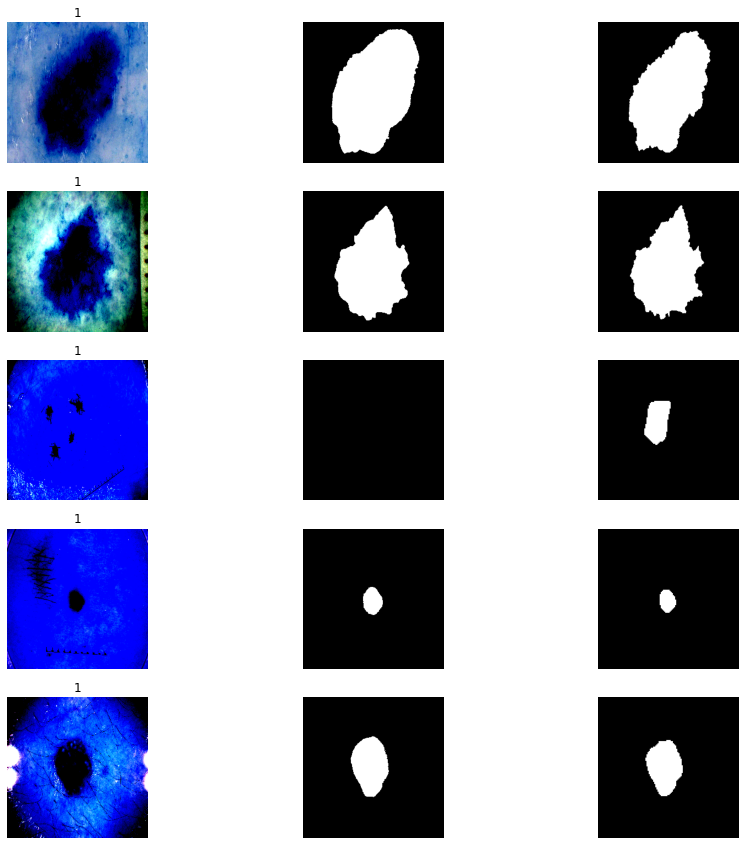

In [ ]:
j = 1
plt.figure(figsize = (15,15))
for i in range(5):
    plt.subplot(5,3,3*i+1)
    plt.axis('off')
    plt.imshow(k[0][i].reshape(256,256,3))
    plt.title(j)
    plt.subplot(5,3,3*i+2)
    plt.axis('off')
    plt.imshow(create_mask(out[i]), cmap = 'gray')
    plt.subplot(5,3,3*i+3)
    plt.axis('off')
    plt.imshow(k[1][i].reshape(256,256), cmap = 'gray')


In [5]:
!tree /content/drive/My\ Drive/Mic\ Project -d

/content/drive/My Drive/Mic Project
├── code
│   ├── notebooks
│   ├── saved_models
│   │   ├── bad_model_no_norm
│   │   │   ├── assets
│   │   │   └── variables
│   │   ├── final0
│   │   │   ├── assets
│   │   │   └── variables
│   │   ├── final1
│   │   │   ├── assets
│   │   │   └── variables
│   │   ├── final2
│   │   │   ├── assets
│   │   │   └── variables
│   │   ├── retina_final0
│   │   │   ├── assets
│   │   │   └── variables
│   │   └── retina_final_img_wise_norm
│   │       ├── assets
│   │       └── variables
│   └── src
├── data
│   ├── data_managers
│   ├── isbi
│   │   └── files
│   ├── isic-challenge-2017
│   │   ├── ISIC-2017_Test_Data
│   │   ├── ISIC-2017_Test_GroundTruth
│   │   ├── ISIC-2017_Training_Data
│   │   ├── ISIC-2017_Training_GroundTruth
│   │   ├── ISIC-2017_Validation_Data
│   │   └── ISIC-2017_Validation_GroundTruth
│   └── retina
│       ├── CHASE_DB1
│       ├── DRIVE
│       │   ├── test
│       │   │   ├── images
│       │   │   └── mask
│      

In [3]:
!sudo apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 59 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (47.1 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: